# Final Notebook
### Model of home sale price indicators in King County.



## Contents
- Notebook Summary
- Library and data importing
- EDA
- Data Processing
- Create Baseline Model
- Perform multiple model iterations
- Draw conclusions from final model

# Notebook Summary

This notebook provides a high level summary of the process we undertook to achieve the project task. Our task was to create a linear regression model in order to draw insights on what influences home sale price in King County. Our project audience was potential homebuyers. King County offers available homes at a wide range of prices. We decided to taylor our analysis towards the average home buyer and wanted to reveal what home features influenced home price and by how much. In order to accomplish this task, we utilized data available from [King County Department of Assessments](https://info.kingcounty.gov/assessor/DataDownload/default.aspx). Specifically, we gathered information on property sales, residential building features, and parcel features from the Real Property Sales, Residential Buildings, and Parcel datasets. Documentation for these datasets are available from the data source as well. 

Our initial analysis wanted to explore the effects having a porch, being on the waterfront, and the present of nuisances (traffic noise, powerlines, etc) had on home sale price. In addition to that, we also explored what influence the size, quality, and location of a home had on it's respective sale price.

This notebook will walk through our process of data gathering and exploration, how we processed and analyzed this data, as well as the results of the analysis.

## Data Importing

The following cell allows us to import functions written in our .py files. All of which can be found under the src/ directory of this repo.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import src.mc_functions as mc
import src.jw_total_df as jw

We will begin by importing the data into a pandas dataframe. The function create_dataframe selects the columns from the three datasets we need for our analysis which are as follows.

Property Sales:
- Major
- Minor
- Sale Price

Residential Buildings:
- Major
- Minor
- SqFtTotLiving
- SqFtOpenPorch
- SqFtEnclosedPorch
- BldgGrade
- Bedrooms
- BathFullCount
- BathHalfCount
- SwFtGarageAttached

Parcel:
- Major
- Minor
- TrafficNoise
- PowerLines
- OtherNuisances
- TidelandShoreland
- Township
- SqFtLot

The function join's the columns from these three dataframes on the 'Major' and 'Minor columns which are the unique identifiers of the observations. Our analysis was done specifically on property sales from 2019 so our function filters the resulting dataframe to only include information from that year. It also creates two extra columns 'has_porch' and 'on_water' which indicate whether or not the home has a porch and is on the waterfront


In [3]:
df = mc.create_dataframe()

The dataframe is now imported and stored in variable df. Now we can look at a few rows and make sure all the data looks correct.

In [4]:
df.head()

,Major,Minor,SalePrice,PropertyClass,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,BldgGrade,Bedrooms,BathFullCount,...,TrafficNoise,PowerLines,OtherNuisances,TidelandShoreland,Township,SqFtLot,WfntLocation,WfntAccessRights,has_porch,on_water
0,213043,0120,560000,8,1930,180,0,7,3,2,...,0,0,0,0,26,10523,0,N,1,0
1,940652,0630,435000,8,1975,45,0,7,3,1,...,0,0,0,0,22,7392,0,N,1,0
2,140281,0020,450000,8,1080,110,0,7,3,2,...,0,0,0,0,26,9940,0,N,1,0
3,779790,0030,0,8,890,0,0,7,3,1,...,0,0,0,0,25,5000,0,N,0,0
4,124550,0098,193000,8,1760,0,0,7,3,1,...,1,0,0,0,26,9670,0,N,0,0


Now we can check the datatypes of each variable and whether we have any missing data or not.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43838 entries, 0 to 43837
Data columns (total 21 columns):
Major                43838 non-null object
Minor                43838 non-null object
SalePrice            43838 non-null int64
PropertyClass        43838 non-null int64
SqFtTotLiving        43838 non-null int64
SqFtOpenPorch        43838 non-null int64
SqFtEnclosedPorch    43838 non-null int64
BldgGrade            43838 non-null int64
Bedrooms             43838 non-null int64
BathFullCount        43838 non-null int64
BathHalfCount        43838 non-null int64
TrafficNoise         43838 non-null int64
PowerLines           43838 non-null int64
OtherNuisances       43838 non-null int64
TidelandShoreland    43838 non-null int64
Township             43838 non-null int64
SqFtLot              43838 non-null int64
WfntLocation         43838 non-null int64
WfntAccessRights     43838 non-null object
has_porch            43838 non-null int64
on_water             43838 non-null int64
dtypes

It looks like all the rows are numeric except for three. Also we have no missing data. One thing to notice from the dataframe sample above is that 'SalePrice' has a row with a zero value. This may confuse our model so we will remove all rows that have a sale price of zero

In [6]:
df = df[df['SalePrice'] > 0]

Now we can check the distribution of 'SalePrice' to check for potential outliers. To do this we will use the predefined function 'plot_dist' which creates a seaborn distplot and boxplot of the variable passed in.

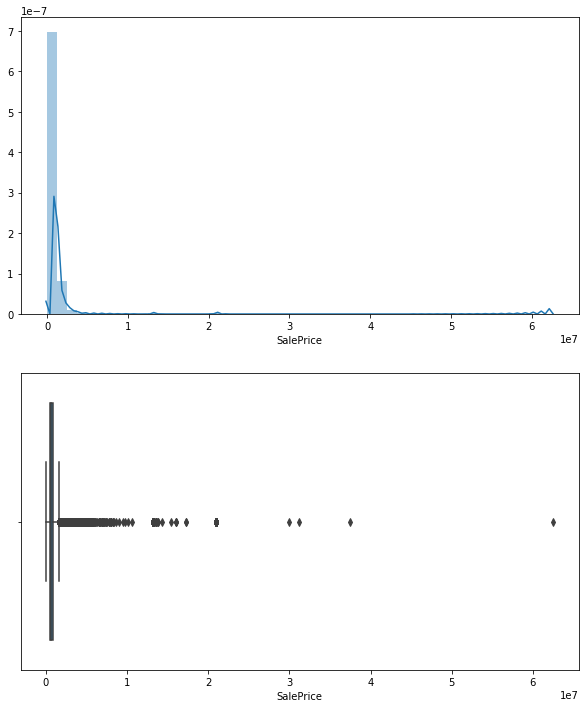

In [7]:
mc.plot_dist(df['SalePrice'])

Both plots show an extremely positive skew and the boxplot indicates there are many extreme outliers. We will need to remove those and try and make this resemble a near normal distribution in order to get the best results from our model. To remove these outliers we will use z-scores. We will consider an outlier to be any value more than 2.5 standard deviations from the mean in any direction. First we will find the z-score of every 'SalePrice' in our dataframe and store it in the list z-score. We will use the z-score function defined in the .py file. First we need to find the mean and standard deviation of 'SalePrice'.

In [8]:
# mean of sale price
mean_sale_price = df['SalePrice'].mean()
# Standard deviation of sale price
std_sale_price = df['SalePrice'].std()

We can now use these values to find the z-score of every sale price value.

In [9]:
z_scores = [mc.z_score(p, mean_sale_price, std_sale_price)
            for p in df['SalePrice']]

Now using this z_scores list, we can create a mask that will filter the dataframe for outliers. The mask will hold a value of 'False' if the z_score is more than 2.5 standard deviations from the mean and 'True' otherwise. This mask will remove the rows from the dataframe that holds a value of 'False'.

In [10]:
outliers = [False if ((z < -2.5) | (z > 2.5)) else True for z in z_scores]
df = df[outliers]

Now that we have removed some outliers we can check the distribution again.

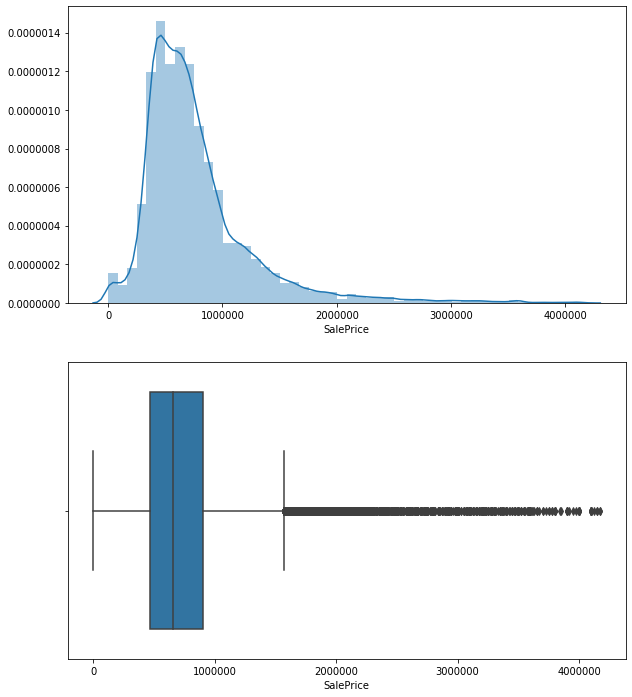

In [11]:
mc.plot_dist(df['SalePrice'])

That distribution looks much better. The mask removed all rows with a 'SalePrice' value above about 4 million. More may need to be removed later, but for now this is good. Now that outliers are removed, we can begin to explore the correlation between home sale price and different home features. We will do this by creating a correlation matrix and a heatmap of this matrix.

In [12]:
df.corr()

,SalePrice,PropertyClass,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,BldgGrade,Bedrooms,BathFullCount,BathHalfCount,TrafficNoise,PowerLines,OtherNuisances,TidelandShoreland,Township,SqFtLot,WfntLocation,has_porch,on_water
SalePrice,1.000000,-0.064384,0.579963,0.274183,0.008230,0.590956,0.281753,0.332216,0.207526,-0.008209,-0.016950,0.008972,0.116278,0.371556,-0.062210,0.077085,0.198509,0.119736
PropertyClass,-0.064384,1.000000,-0.012565,-0.018018,-0.017215,0.007909,-0.000998,0.007269,0.003678,-0.015158,0.006235,-0.020723,0.002024,-0.030616,0.002582,0.005842,-0.009801,0.002231
SqFtTotLiving,0.579963,-0.012565,1.000000,0.411019,-0.014731,0.716409,0.665978,0.607869,0.351765,-0.084745,0.020729,-0.068455,0.033967,0.046901,-0.072310,0.011121,0.321336,0.035037
SqFtOpenPorch,0.274183,-0.018018,0.411019,1.000000,-0.012972,0.294567,0.239536,0.268736,0.150852,-0.033461,0.020187,-0.021724,0.021463,-0.024812,-0.002143,0.062423,0.497503,0.023286
SqFtEnclosedPorch,0.008230,-0.017215,-0.014731,-0.012972,1.000000,-0.017620,-0.023361,-0.044105,-0.022843,0.036804,-0.008124,0.006426,0.015128,0.008177,-0.006054,0.013535,0.144049,0.016422
BldgGrade,0.590956,0.007909,0.716409,0.294567,-0.017620,1.000000,0.404005,0.484561,0.392336,-0.084935,0.004380,-0.042936,0.041366,0.152246,-0.158044,-0.044714,0.261410,0.042663
Bedrooms,0.281753,-0.000998,0.665978,0.239536,-0.023361,0.404005,1.000000,0.495557,0.197524,-0.082532,0.015906,-0.057990,-0.036211,-0.022140,-0.156065,-0.100416,0.197868,-0.036357
BathFullCount,0.332216,0.007269,0.607869,0.268736,-0.044105,0.484561,0.495557,1.000000,0.232441,-0.068358,0.013092,-0.025566,-0.009522,-0.005571,-0.098633,-0.049275,0.259349,-0.009796
BathHalfCount,0.207526,0.003678,0.351765,0.150852,-0.022843,0.392336,0.197524,0.232441,1.000000,-0.057571,0.015263,-0.030080,-0.001854,-0.011771,-0.039178,-0.015546,0.144426,-0.001458
TrafficNoise,-0.008209,-0.015158,-0.084745,-0.033461,0.036804,-0.084935,-0.082532,-0.068358,-0.057571,1.000000,-0.010716,0.044730,0.024862,0.073864,0.144746,0.073428,-0.037544,0.023369


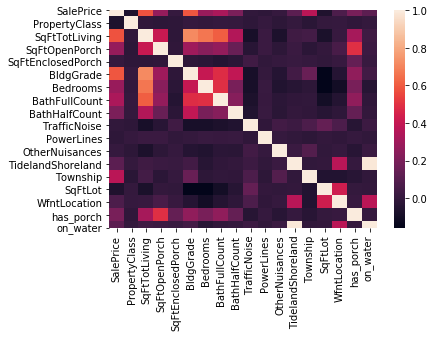

In [13]:
mc.corr_heatmap(df)

As we can see the features that seem to influence 'SalePrice' the most are home square footage, building grade which relates to the quality of the home, township which is the area the home is located, and the number of bedrooms and bathrooms in the home. In terms of the claims we are exploring, nuisances seem to have very little effect on home sale price. Waterfront homes seem to be a little more expensive as do homes with a porch of somekind. Knowing this information, we can proceed to creating our baseline model.

## Baseline Model

From the correlation plot above, we can see that the total square footage of a home strongly influences the sale price. This is a simple idea and since it has such a strong correlation, this is the feature we will use to create our baseline model.

In [14]:
model_df = df[['SalePrice', 'SqFtTotLiving']]
model_df = model_df[model_df['SalePrice'] < 2000000]
y = model_df.SalePrice #target
x = model_df.drop('SalePrice', axis=1) # features
model = mc.create_model(x, y)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.845
Model:                            OLS   Adj. R-squared (uncentered):              0.845
Method:                 Least Squares   F-statistic:                          1.560e+05
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:50:05   Log-Likelihood:                     -4.0418e+05
No. Observations:               28717   AIC:                                  8.084e+05
Df Residuals:                   28716   BIC:                                  8.084e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   319.2959      0.808    394.939      0.000     317.711     320.881
==============================================================================
Omnibus:                     3145.595   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27660.177
Skew:                          -0.141   Prob(JB):                         0.00
Kurtosis:                       7.800   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Utilizing the predefined function 'test_assumptions', we can check the assumptions of linear regression of this model to see how well it performed.